# 1. Regresión

Revisaremos los conceptos de regresión vistos en el teórico.

Haremos pruebas con datos de entrada de **una dimensión**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True) # No usar notación 'e'

## Función Verdadera Oculta

Usaremos como función oculta un *sinusoide*.

In [2]:
def create_sinusoidal_data(spread=0.25, data_size=50):
    np.random.seed(0)
    x = np.linspace(0, 1, data_size)
    y = np.sin(2 * np.pi * x) + np.random.normal(scale=spread, size=x.shape)

    return x, y

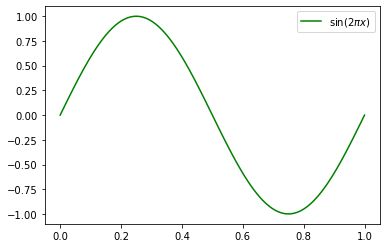

In [3]:
# Función Verdadera (sin ruido)
x, f_x = create_sinusoidal_data(0, 100)

plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

## Muestra Ruidosa

Tomaremos puntos uniformes en $x$, ruidosos en $y$.

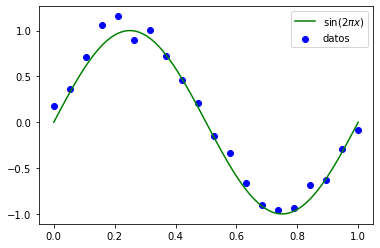

In [4]:
noise = 0.10
data_size = 20

X, y = create_sinusoidal_data(noise, data_size)

plt.scatter(X, y, color="blue", label="datos")
plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

In [5]:
X

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [6]:
y

array([ 0.17640523,  0.36471519,  0.71208651,  1.0612558 ,  1.15615606,
        0.89885671,  1.01078217,  0.72058819,  0.46562551,  0.20565444,
       -0.15019023, -0.33052004, -0.65962014, -0.90360583, -0.95219817,
       -0.93603283, -0.68775857, -0.63472854, -0.2933927 , -0.08540957])

## División en Entrenamiento y Evaluación

Dividiremos aleatoriamente los datos en una parte para entrenamiento, y otra para evaluación.

Usaremos [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) de scikit-learn.

In [7]:
from sklearn.model_selection import train_test_split

# Se toma una muestra de entrenamiento pequeña.
train_size = 5
# En comparación, la muestra de test es grande.
test_size = data_size - train_size

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)

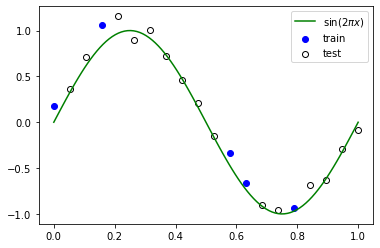

In [8]:
# Graficamos el conjunto de datos, y la función a predecir.
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")

plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

## Regresión Lineal

Probaremos ajustar los puntos usando una recta.

Vamos a programar a mano el aprendizaje y la predicción.

### Solución de Cuadrados Mínimos

Datos de entrenamiento:
- $X \in R^{N \times K}:$ $N$ vectores de entrada, de $K$ dimensiones cada uno.
- $y \in R^N:$ $N$ valores de salida.

Aprendizaje:

$$w^* = (X^\top X)^{-1} X^\top y$$

Predicción:

$$f_{w^*}(x) = x^\top w^* = \sum_{k=1}^K x_k w^*_k$$

Con $K=1$ tendríamos:

$$f_{w^*}(x) = x_1 w_1^*$$

Para que sea una recta nos falta un $w_0^*$ (**bias**).
Esto se puede resolver haciendo $K=2$, y agregando un valor constante $1$ a cada dato:

$$f_{w^*}([1, x]) = w_0^* + x_1 w_1^*$$

In [9]:
X_train.shape

(5,)

In [10]:
X_train_bias = np.stack((np.ones(X_train.shape[0]), X_train), axis=1) # add bias

X_train_bias

array([[1.        , 0.57894737],
       [1.        , 0.15789474],
       [1.        , 0.        ],
       [1.        , 0.78947368],
       [1.        , 0.63157895]])

In [11]:
X_train_bias.shape

(5, 2)

In [12]:
def linear_least_squares(X, y):
    """
    Aprendizaje de parámetros W.
    """
    Z = np.stack((np.ones(X.shape[0]), X), axis=1) # add bias
    return np.linalg.pinv(Z.T.dot(Z)).dot(Z.T.dot(y))

def f(X, w):
    """
    Predicción con parámetros W.
    """
    Z = np.stack((np.ones(X.shape[0]), X), axis=1) # add bias
    return Z.dot(w)

### Entrenar

In [13]:
X_train, y_train

(array([0.57894737, 0.15789474, 0.        , 0.78947368, 0.63157895]),
 array([-0.33052004,  1.0612558 ,  0.17640523, -0.93603283, -0.65962014]))

In [14]:
w = linear_least_squares(X_train, y_train)

**¿Qué dimensiones tiene $w$?**

Tendrá dos dimensiones, $w_0$ y $w_1$.

In [15]:
w

array([ 0.70657973, -1.95626346])

### Graficar

Graficaremos la función aprendida a partir de los datos de entrenamiento. También graficaremos con los datos de evaluación y la función oculta, para comparar.

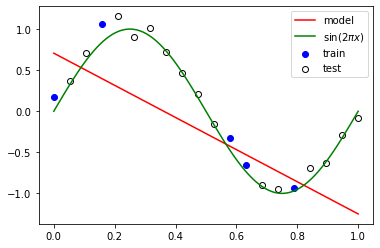

In [16]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")

plt.plot(x, f(x, w), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

### Predecir y Evaluar: Error Cuadrático Medio

Obtendremos los valores predichos para los datos de entrenamiento y de evaluación.
Calcularemos el *error cuadrático medio* sobre ambos conjuntos de datos.

In [17]:
y_train_pred = f(X_train, w)
y_test_pred = f(X_test, w)

Usamos la función [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) de *scikit-learn*:

In [18]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print(f'Train error: {train_error:f}')
print(f'Test error: {test_error:f}')

Train error: 0.151445
Test error: 0.381363


## Regresión Polinomial

Ahora haremos **regresión polinomial**. En este caso usaremos *scikit-learn* para definir el modelo, entrenar, y predecir.

En *scikit-learn* cada dato de entrada debe ser un vector, no un número. Debemos convertir cada dato en un vector de una dimensión:

In [19]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

X_train.shape, X_test.shape

((5, 1), (15, 1))

### Features Polinomiales

En *scikit-learn*, la **regresión polinomial** se implementa como un modelo de dos pasos.

El primer paso genera vectores de características polinomiales, y el segundo paso aplica una **regresión lineal** sobre estos vectores (ver [Polynomial interpolation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html)).

Por ejemplo, para generar características polinomiales de grado $5$:

In [20]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(5) # Polinomio de grado 5
pf.fit(X_train)            # No necesita y_train

PolynomialFeatures(degree=5)

**¿Cuántos componentes tiene $X_{trainP}$?**

Tendrá seis componentes, $x^0$, $x^1$, $x^2$, $x^3$, $x^4$, y $x^5$.

In [21]:
X_trainP = pf.transform(X_train)

X_trainP.shape

(5, 6)

In [22]:
X_train[0]

array([0.57894737])

In [23]:
X_trainP[0]

array([1.        , 0.57894737, 0.33518006, 0.19405161, 0.11234567,
       0.06504223])

### Instanciar y Entrenar

Crearemos y entrenaremos un modelo de grado $2$.

Como siempre en *scikit-learn*, para entrenar usamos la función **fit**.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

degree = 2

pf = PolynomialFeatures(degree)
lr = LinearRegression(fit_intercept=False) # bias ya es un feature

model = make_pipeline(pf, lr)

In [25]:
model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression(fit_intercept=False))])

**Equivalente a...**
```
Z_train = pf.fit_transform(X_train)
lr.fit(Z_train, y_train)
```

### Inspeccionar Parámetros

Ver [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [26]:
lr.coef_

array([ 0.45340784,  1.62753594, -4.67896686])

In [27]:
lr.intercept_

0.0

### Graficar Resultado

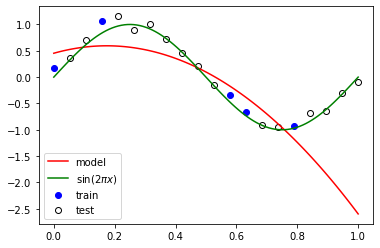

In [28]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")

plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

### Predecir y Evaluar

Para predecir, usamos la función **predict**:

In [29]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [30]:
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print(f'Train error: {train_error:0.2}')
print(f'Test error: {test_error:0.2}')

Train error: 0.091
Test error: 0.87


## Sobreajuste vs. Generalización

Probaremos polinomios de varios grados, obteniendo valores de error en entrenamiento y evaluación:

In [31]:
train_errors = []
test_errors = []
params = []
degrees = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for degree in degrees:
    # train:
    pf = PolynomialFeatures(degree)
    lr = LinearRegression(fit_intercept=False)
    model = make_pipeline(pf, lr)
    model.fit(X_train, y_train)

    # predict:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

    # parameters (saved for later...):
    lr = model.named_steps['linearregression']
    params.append(lr.coef_)

In [32]:
for d, trainE, testE in zip(degrees, train_errors, test_errors):
    print(f'Degree {d} | Train Error {trainE:0.3} | Test Error {testE:0.3}')

Degree 0 | Train Error 0.497 | Test Error 0.539
Degree 1 | Train Error 0.151 | Test Error 0.381
Degree 2 | Train Error 0.0908 | Test Error 0.869
Degree 3 | Train Error 0.000896 | Test Error 0.0177
Degree 4 | Train Error 1.38e-29 | Test Error 0.762
Degree 5 | Train Error 1.27e-30 | Test Error 0.995
Degree 6 | Train Error 4.85e-30 | Test Error 1.2
Degree 7 | Train Error 2.48e-30 | Test Error 1.33
Degree 8 | Train Error 3.63e-29 | Test Error 1.39
Degree 9 | Train Error 3.45e-28 | Test Error 1.37


Graficaremos las curvas de error, en términos del grado del polinomio.

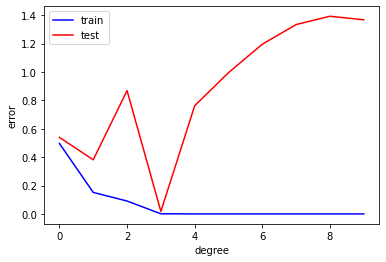

In [33]:
plt.plot(degrees, train_errors, color="blue", label="train")
plt.plot(degrees, test_errors, color="red", label="test")

plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

Se puede ver que el error en entrenamiento siempre baja, pero que en algún punto comienza el *sobreajuste*, ya que el error en evaluación empieza a subir.

### Mejor Modelo

De acuerdo a la gráfica anterior, y como era de esperarse, el modelo que mejor ajusta los datos es el de grado $3$:

In [34]:
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept=False))
model.fit(X_train, y_train);

Graficamos:

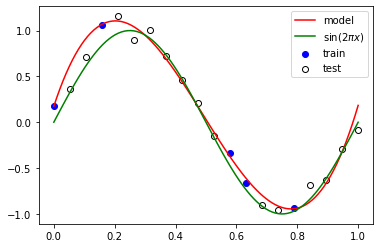

In [35]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")

plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

In [36]:
train_errors[degree], test_errors[degree]

(0.000895508590010494, 0.017667168775629283)

### Modelo Sobreajustado

Veamos cómo es la gráfica de uno de los modelos que sufre de sobreajuste:

In [37]:
degree = 8
model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept=False))
model.fit(X_train, y_train);

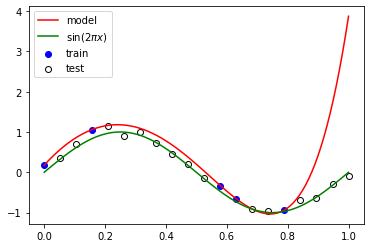

In [38]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")

plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

In [39]:
train_errors[degree], test_errors[degree]

(3.63050120468638e-29, 1.3926020261709986)

## Ejercicios

1. Probar agregando puntos a los datos de entrenamiento para prevenir el sobreajuste en polinomios de grado alto.
2. Imprimir los parámetros de los modelos para cada grado.
3. Probar usando regularización para prevenir el sobreajuste en polinomios de grado alto
(ver [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)).
4. Hicimos todo con datos de entrada de una dimensión. ¿Cómo serían los features polinomiales en datos de más dimensiones?

**Ejercicio 1**

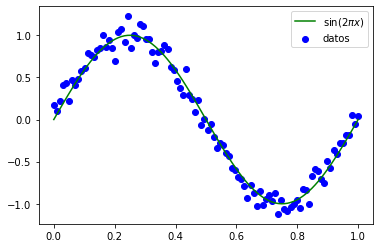

In [40]:
noise = 0.10
data_size = 100

X, y = create_sinusoidal_data(noise, data_size)

plt.scatter(X, y, color="blue", label="datos")
plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

In [41]:
train_size = 50
test_size = data_size - train_size

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)

In [42]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

X_train.shape, X_test.shape

((50, 1), (50, 1))

In [43]:
degree = 8
model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept=False))
model.fit(X_train, y_train);

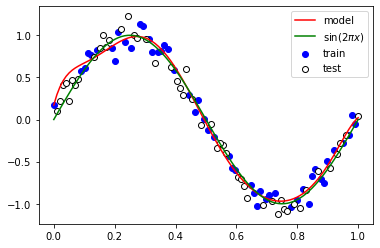

In [44]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")

plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

In [45]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print(f'Train error: {train_error:0.2}')
print(f'Test error: {test_error:0.2}')

Train error: 0.0077
Test error: 0.015


**Ejercicio 2**

In [46]:
for d, coefs in zip(degrees, params):
    print(f'Degree {d}')
    print(f'Coefficients {coefs}')

Degree 0
Coefficients [-0.1377024]
Degree 1
Coefficients [ 0.70657973 -1.95626346]
Degree 2
Coefficients [ 0.45340784  1.62753594 -4.67896686]
Degree 3
Coefficients [  0.17374917  10.08806898 -31.41746612  21.33946075]
Degree 4
Coefficients [  0.17640523   7.22537635  -5.49087049 -36.09732731  36.98528755]
Degree 5
Coefficients [  0.17640523   7.94652575 -13.3590475  -10.19531626   2.84371968
  15.82170218]
Degree 6
Coefficients [  0.17640523   8.18582665 -15.65519385  -5.03453181   2.82029489
   6.16954779   6.90594919]
Degree 7
Coefficients [  0.17640523   8.26194631 -16.33153597  -3.85590113   3.37188552
   5.09044713   4.29130785   2.77912154]
Degree 8
Coefficients [  0.17640523   8.27893843 -16.47530597  -3.64710124   3.52310912
   5.00266973   3.96471219   2.28375142   0.76464833]
Degree 9
Coefficients [  0.17640523   8.27465747 -16.44024812  -3.6915704    3.48357133
   5.00778215   4.01675975   2.37005958   0.87002874  -0.23334699]


**Ejercicio 3**

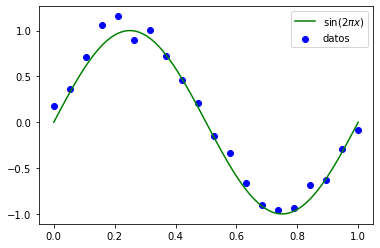

In [47]:
noise = 0.10
data_size = 20

X, y = create_sinusoidal_data(noise, data_size)

plt.scatter(X, y, color="blue", label="datos")
plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

In [48]:
train_size = 5
test_size = data_size - train_size

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)

In [49]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

X_train.shape, X_test.shape

((5, 1), (15, 1))

In [50]:
from sklearn.linear_model import Ridge

degree = 8
model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.005, fit_intercept=False))
model.fit(X_train, y_train);

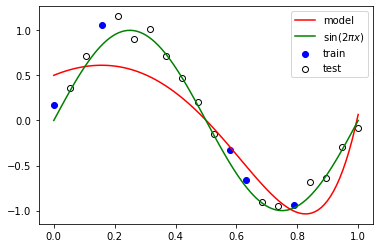

In [51]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")

plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2 \pi x)$")

plt.legend()
plt.show()

In [52]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print(f'Train error: {train_error:0.2}')
print(f'Test error: {test_error:0.2}')

Train error: 0.067
Test error: 0.085


**Ejercicio 4**

[PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.
For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

Be aware that the number of features in the output array scales polynomially in the number of features of the input array, and exponentially in the degree.
High degrees can cause overfitting.

In [53]:
array = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

array.shape

(3, 3)

In [54]:
pf = PolynomialFeatures(2, include_bias=False) # Polinomio de grado 2

arrayP = pf.fit_transform(array)
arrayP.shape

(3, 9)

In [55]:
array

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [56]:
arrayP

array([[ 1.,  2.,  3.,  1.,  2.,  3.,  4.,  6.,  9.],
       [ 4.,  5.,  6., 16., 20., 24., 25., 30., 36.],
       [ 7.,  8.,  9., 49., 56., 63., 64., 72., 81.]])

## Referencias

Scikit-learn:

- [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
- [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)